# 3b - Training with built-in XGBoost <a class="anchor" id="top"></a>
* [Introduction](#intro)
* [Setup](#setup)
* [Estimator creation](#estim)
    * [Define estimator](#define)
    * [Train estimator and tune parameters](#tune)
* [Evaluate training result](#eval)
    * [Create endpoint to test model](#endpoint)
    * [ Analysis of training results](#analysis)
* [Cleanup resources](#clean)

## Introduction <a class="anchor" id="intro"></a>
In this notebook, we will train an XGBoost model, evaluate the training performance, and output model artifacts.
XGBoost is a regularizing gradient boosting framework with proven performance in ML competitions.
Additionally, the algorithm has a variety of hyperparameters, which allows for signigicant gains to be had by way of tuning.
We will be using Amazon's built-in XGBoost implementation, which integrates nicely with their hyperparameter tuner.

## Setup <a class="anchor" id="setup"></a>
First, we import Sageamker SDK dependencies as well as modules used in application below.
We also get relevant sessions and read in local environment data.

In [1]:
import json
import uuid
import boto3
import random
import tarfile
import pickle as pkl
import datetime as dt
import sagemaker as sm
import sagemaker.xgboost as xgb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
sns.set_style("darkgrid")

In [2]:
sm_session = sm.Session()
role = sm.get_execution_role()
boto3_session = boto3.session.Session()
now = dt.datetime.now().strftime(r"%Y%m%dT%H%M%S")

In [3]:
# Get boto3 session attributes.
account = boto3_session.client("sts").get_caller_identity()["Account"]
region = boto3_session.region_name

# Create clients to access S3.
s3_client = boto3_session.client("s3")
s3_resource = boto3_session.resource("s3")

In [4]:
# Retrieve data and model bucket names.
with open("/home/ec2-user/.aiml-bb/stack-data.json", "r") as f:
    data = json.load(f)
    data_bucket = data["data_bucket"]
    model_bucket = data["model_bucket"]

## Estimator creation <a class="anchor" id="estim"></a>
We can now create the XGBoost estimator, using Amazon's built-in implementation.
Because the model is managed for us, there is little to do in way of setup.

### Define estimator <a class="anchor" id="define"></a>
Here we create the `Estimator` object, and all resources that are required to do so.

In [5]:
# Get XGBoost container image for current region.
xgb_container_image = sm.image_uris.retrieve("xgboost", region, "latest")

# Create a unique training job name.
training_job_name = f"xgboost-{str(uuid.uuid4())[:8]}"

In [6]:
train_input = sm.inputs.TrainingInput(
    s3_data=f"s3://{data_bucket}/preprocessing_output/train/", 
    content_type="csv"
)
validation_input = sm.inputs.TrainingInput(
    s3_data=f"s3://{data_bucket}/preprocessing_output/validation/",
    content_type="csv"
)

In [7]:
# Create estimator running the XGBoost container.
xgb_estimator = sm.estimator.Estimator(
    xgb_container_image,
    role, 
    instance_count=1, 
    instance_type="ml.m5.4xlarge",
    volume_size=20,
    output_path=f"s3://{model_bucket}/sagemaker-xgboost/"
)

### Train estimator and tune parameters <a class="anchor" id="tune"></a>
Hyperparameters are now defined as well as valid ranges.
We then attach a `HyperparameterTuner` and fit the tuner.

In [8]:
# Define starting hyperparameters for the model.
xgb_estimator.set_hyperparameters(
    eval_metric="auc",
    objective="binary:logistic",
    max_depth=6,
    eta=0.2,
    alpha=2.0,
    gamma=4,
    min_child_weight=8,
    subsample=0.8,
    silent=0,
    num_round=100,
    early_stopping_rounds=25
)
# Set ranges of XGBoost hyperparameters for tuning.
xgb_hyperparameter_ranges = {
    "eta": sm.tuner.ContinuousParameter(0, 1),
    "alpha": sm.tuner.ContinuousParameter(0, 3),
    "min_child_weight": sm.tuner.ContinuousParameter(1, 10),
    "max_depth": sm.tuner.IntegerParameter(1, 10)
}

In [ ]:
# Create tuner and fit.
xgb_objective_metric_name = "validation:auc"
xgb_tuner = sm.tuner.HyperparameterTuner(
    xgb_estimator,
    xgb_objective_metric_name,
    xgb_hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=5,
    strategy="Bayesian"
)
xgb_tuner.fit(
    {"train": train_input, "validation": validation_input}
)

.................................................................................................................................................................................................................................................................................................................

### Select best model <a class="anchor" id="select-best"></a>
View the analytics from the tuning job and select the best model.
We then store the best model in location that we can reference more easily in other notebooks.

In [16]:
# View analytics on tuning job results.
xgb_tuner_analytics = sm.HyperparameterTuningJobAnalytics(
    xgb_tuner.describe()["HyperParameterTuningJobName"]
)
xgb_tuner_analytics.dataframe().sort_values("FinalObjectiveValue")

,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
17,2.960058,0.586967,1.0,9.577117,xgboost-220128-0531-003-2bf3d04b,Completed,0.656054,2022-01-28 05:34:40+00:00,2022-01-28 05:47:10+00:00,750.0
16,0.249053,0.119487,3.0,8.489674,xgboost-220128-0531-004-2ebd4f29,Completed,0.659975,2022-01-28 05:34:32+00:00,2022-01-28 05:51:19+00:00,1007.0
19,0.771090,0.385532,3.0,8.382130,xgboost-220128-0531-001-6ca96870,Completed,0.668474,2022-01-28 05:34:22+00:00,2022-01-28 05:50:31+00:00,969.0
13,0.248720,0.216658,6.0,3.759545,xgboost-220128-0531-007-284052aa,Completed,0.677053,2022-01-28 05:53:25+00:00,2022-01-28 06:17:28+00:00,1443.0
14,0.248720,0.216658,6.0,3.579545,xgboost-220128-0531-006-5b6cac29,Completed,0.677087,2022-01-28 05:51:59+00:00,2022-01-28 06:15:47+00:00,1428.0
10,1.815919,0.103906,10.0,1.958336,xgboost-220128-0531-010-4e08b5b4,Completed,0.685217,2022-01-28 06:14:05+00:00,2022-01-28 06:51:12+00:00,2227.0
9,1.918233,0.124037,10.0,2.573472,xgboost-220128-0531-011-a0a3ccdf,Completed,0.687021,2022-01-28 06:19:08+00:00,2022-01-28 06:57:01+00:00,2273.0
18,0.689974,0.405651,9.0,8.484161,xgboost-220128-0531-002-a173c619,Completed,0.694557,2022-01-28 05:34:34+00:00,2022-01-28 06:07:40+00:00,1986.0
3,0.061311,0.950189,10.0,5.337632,xgboost-220128-0531-017-29220a2d,Completed,0.696889,2022-01-28 07:00:18+00:00,2022-01-28 07:37:33+00:00,2235.0
4,0.344392,0.992303,10.0,2.352471,xgboost-220128-0531-016-50f0ab24,Completed,0.697327,2022-01-28 07:00:33+00:00,2022-01-28 07:38:13+00:00,2260.0


In [17]:
# Take best model and copy to location we can reference in other notebooks.
xgb_best_training_job_name = xgb_tuner.best_training_job()
xgb_best_training_job_key = f"sagemaker-xgboost/{xgb_best_training_job_name}/output/model.tar.gz"
copy_source = {
    "Bucket": model_bucket,
    "Key": xgb_best_training_job_key
}
s3_resource.Bucket(model_bucket).copy(
    copy_source, 
    "sagemaker-xgboost-tuned/model.tar.gz"
) 

## Evaluate training results <a class="anchor" id="eval"></a>
Lastly, we evaluate the results of training against the testing data set.
To test this model, we will create and endpoint that we can send the testing data to synchronously.
Note that this data set is not included in training and has never been seen by the model.

### Create endpoint to test model <a class="anchor" id="endpoint"></a>

In [18]:
# Create model and endpoint from best fitted estimator above.
xgb_model = sm.model.Model(
    image_uri=xgb_container_image,
    model_data=f"s3://{model_bucket}/sagemaker-xgboost-tuned/model.tar.gz",
    role=role
)
endpoint_name = f"xgb-test-endpt-{now}"
xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=endpoint_name
)

-----!

In [19]:
# Connect a predictor to the endpoint for inference.
xgb_predictor = sm.predictor.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sm_session,
    serializer=sm.serializers.CSVSerializer(
        content_type="text/csv"
    )
)

In [ ]:
# Iterate over testing data and compute statistics.
list_objs_response = s3_client.list_objects_v2(
    Bucket=data_bucket, 
    Prefix="preprocessing_output/train"
)

# Arrays to keep track of results.
test_actuals = []
test_predictions = []
for obj in list_objs_response["Contents"]:
    
    # Iterate over lines in object contents via stream.
    obj_resource = s3_resource.Object(data_bucket, obj["Key"])
    for line in obj_resource.get()["Body"].iter_lines():
        target, features = line.decode("utf-8").split(",", maxsplit=1)
        features = features.strip()
        prediction = xgb_predictor.predict(features)
        
        test_actuals.append(float(target))
        test_predictions.append(float(prediction))

### Analysis of training results <a class="anchor" id="analysis"></a>
Lastly, we analyze the performance of the model against the testing data set.

In [23]:
# Wrap lists in numpy arrays for analysis.
test_actuals_np = np.array(test_actuals)
test_predictions_np = np.array(test_predictions)
test_predictions_binned_np = np.where(test_predictions_np > 0.5, 1, 0)

In [24]:
# Compute summary statistics on perfomance.
performance_statistics = {
    "accuracy": metrics.accuracy_score(test_actuals_np, test_predictions_binned_np),
    "precision": metrics.precision_score(test_actuals_np, test_predictions_binned_np),
    "recall": metrics.recall_score(test_actuals_np, test_predictions_binned_np),
    "f1": metrics.f1_score(test_actuals_np, test_predictions_binned_np),
    "auc": metrics.roc_auc_score(test_actuals_np, test_predictions_binned_np),
}
print(json.dumps(performance_statistics, indent=4))

{
    "accuracy": 0.6537939431458201,
    "precision": 0.6669287977457574,
    "recall": 0.6040933795006519,
    "f1": 0.6339578939359998,
    "auc": 0.6534272581676551
}


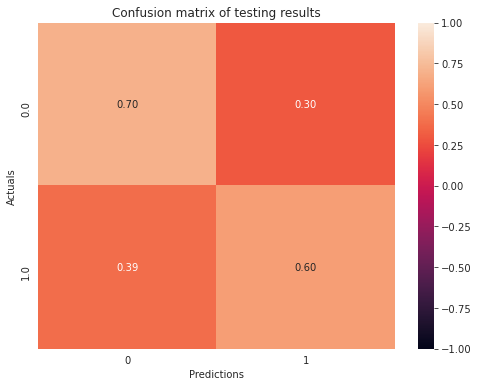

In [25]:
# Compute confusion matrix.
confusion_df = pd.crosstab(
    test_actuals_np, 
    test_predictions_binned_np, 
    rownames=["Actuals"], 
    colnames=["Predictions"]
)
norm_confusion_df = confusion_df / confusion_df.sum(axis=1)

# Show confusion matrix.
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    norm_confusion_df, 
    vmin=-1.0, vmax=1.0, annot=True, fmt=".2f", 
    ax=ax
)
ax.set_title("Confusion matrix of testing results")
plt.show()

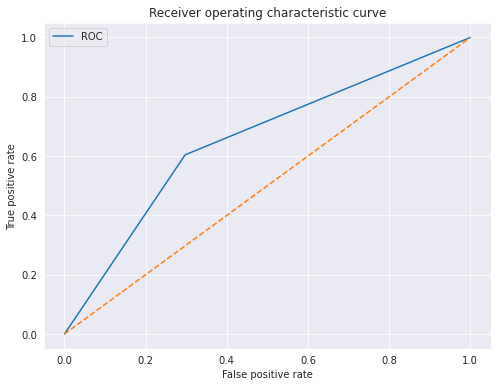

In [26]:
# Compute ROC curve.
fpr, tpr, thresholds = metrics.roc_curve(test_actuals_np, test_predictions_binned_np)

# Plot ROC matrix.
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label="ROC")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Receiver operating characteristic curve")
ax.legend()
plt.show()

## Cleanup resources <a class="anchor" id="clean"></a>
Because this is a temporary project, delete the endpoint.

In [27]:
xgb_predictor.delete_endpoint()